In [1]:
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve
import warnings

data = pd.read_csv('Phishing_Email.csv', encoding='latin-1')
data = data.drop("Unnamed: 0", axis=1)
data = data.rename(columns={"Email Text" : "text", "Email Type":"label"})
# Modify labels to 'safe' and 'phishing'
data['label'] = data['label'].map({'Safe Email': 'safe', 'Phishing Email': 'phishing'})
data.head()

,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",safe
1,the other side of * galicismos * * galicismo *...,safe
2,re : equistar deal tickets are you still avail...,safe
3,\nHello I am your hot lil horny toy.\n I am...,phishing
4,software at incredibly low prices ( 86 % lower...,phishing


In [2]:
data['label'].value_counts()

label
safe        11322
phishing     7328
Name: count, dtype: int64

In [3]:
# # Import nltk packages and Punkt Tokenizer Models
# import nltk
# nltk.download("punkt")
# import warnings
# warnings.filterwarnings('ignore')

# safe_words = ''
# phishing_words = ''
# # Creating a corpus of spam messages
# for val in data[data['label'] == 'safe'].text:
#     text = val.lower()
#     tokens = nltk.word_tokenize(text)
#     for words in tokens:
#         safe_words = safe_words + words + ' '

# # Creating a corpus of ham messages
# for val in data[data['label'] == 'phishing'].text:
#     text = text.lower()
#     tokens = nltk.word_tokenize(text)
#     for words in tokens:
#         phishing_words = phishing_words + words + ' '

In [4]:
# safe_wordcloud = WordCloud(width=500, height=300).generate(safe_words)
# phishing_wordcloud = WordCloud(width=500, height=300).generate(phishing_words)

# # Word cloud
# plt.figure( figsize=(10,8), facecolor='w')
# plt.imshow(safe_wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

# plt.figure( figsize=(10,8), facecolor='g')
# plt.imshow(phishing_wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

In [5]:
data = data.replace(['safe','phishing'],[0, 1])
data.head(10)

,text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1
5,global risk management operations sally congra...,0
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",0
7,"entourage , stockmogul newsletter ralph velez ...",1
8,"we owe you lots of money dear applicant , afte...",1
9,re : coastal deal - with exxon participation u...,0


In [6]:
import string
from nltk.corpus import stopwords

def text_process(text):
    # Check if the text is NaN (float type)
    if isinstance(text, float) and np.isnan(text):
        return ""

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()

,text,label
0,6 1100 disc uniformitarianism 1086 sex lang di...,0
1,side galicismos galicismo spanish term names i...,0
2,equistar deal tickets still available assist r...,0
3,Hello hot lil horny toy one dream open minded ...,1
4,software incredibly low prices 86 lower draper...,1


In [7]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

In [8]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(18650, 189107)

In [9]:
features = vectors

X_train, X_test, y_train, y_test = train_test_split(
    features, label, test_size=0.2, stratify=label
)

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=42,
)

from sklearn.svm import SVC
svc = SVC(
    C=1.0,                 # Regularization parameter
    kernel='sigmoid',      # Kernel type ('linear', 'poly', 'rbf', 'sigmoid', etc.)
    degree=3,              # Degree of the polynomial kernel function (only for 'poly')
    gamma=1.0,             # Kernel coefficient (only for 'rbf', 'poly', and 'sigmoid')
    coef0=0.0,             # Independent term in kernel function (only for 'poly' and 'sigmoid')
    shrinking=True,        # Whether to use the shrinking heuristic
    probability=False,     # Whether to enable probability estimates
    tol=0.001,             # Tolerance for stopping criterion
    class_weight='balanced',     # Weights for classes (balanced or custom)
    verbose=False,         # Verbosity level
    max_iter=-1,           # Maximum number of iterations (-1 for no limit)
    decision_function_shape='ovr',  # Decision function type ('ovr' or 'ovo')
    random_state=None   # Seed for random number generator
)

In [11]:
from sklearn.metrics import accuracy_score

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

E:\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 96.81%


In [12]:
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

E:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 97.64%


              precision    recall  f1-score   support

        safe       0.98      0.97      0.97      2264
    phishing       0.95      0.97      0.96      1466

    accuracy                           0.97      3730
   macro avg       0.96      0.97      0.97      3730
weighted avg       0.97      0.97      0.97      3730



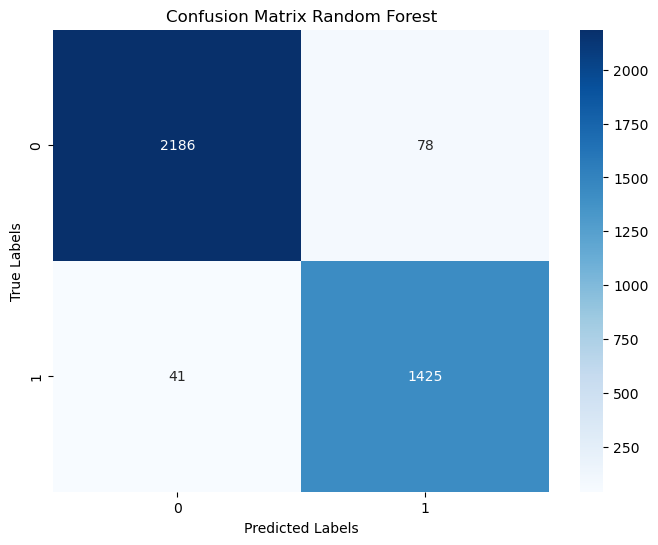

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung Confusion Matrix dari hasil testing
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

class_names = ['safe', 'phishing']
print(classification_report(y_test, y_pred, target_names=class_names))

# Menampilkan Confusion Matrix dengan judul
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Random Forest")
plt.show()

              precision    recall  f1-score   support

        safe       0.99      0.97      0.98      2264
    phishing       0.95      0.99      0.97      1466

    accuracy                           0.98      3730
   macro avg       0.97      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



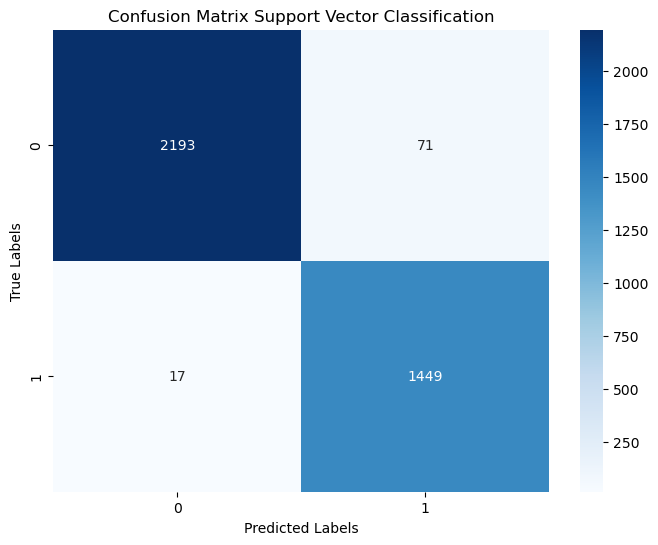

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Menghitung Confusion Matrix dari hasil testing
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

class_names = ['safe', 'phishing']
print(classification_report(y_test, y_pred, target_names=class_names))

# Menampilkan Confusion Matrix dengan judul
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Support Vector Classification")
plt.show()

In [17]:
import joblib

# Save the trained model using joblib
joblib.dump(svc, 'svm_model.joblib')

['svm_model.joblib']

In [18]:
import pickle

filename = 'trainmodel.sav'
pickle.dump(svc, open(filename, 'wb'))

In [20]:
# Fit and save the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(data['text'])
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']